In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA


Datos de los gases de efecto invernadero Globales (datos de NOAA) 

- <b>Ref</b>: Dr. Pieter Tans, NOAA/GML (gml.noaa.gov/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

https://gml.noaa.gov/ccgg/trends/data.html

In [2]:
def read_data_annual(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df=df.set_index("year")
    df.index = pd.to_datetime(df.index,format='%Y')
    df.rename(columns={"mean": gas},inplace=True)
    return df

def read_data_monthly(file,gas):
    file_path=file
    df=pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df=df.set_index("date")
    df.drop("year",axis=1,inplace=True)
    df.drop("month",axis=1,inplace=True)
    df.drop("decimal",axis=1,inplace=True)
    
    if gas == "CO2":
        df.rename(columns={"average": gas},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
    else:
        df.rename(columns={"average": gas,"average_unc":"unc"},inplace=True) 
        df.drop("trend",axis=1,inplace=True)
        df.drop("trend_unc",axis=1,inplace=True)
    return df

In [3]:
# Leemos los ficheros y modificamos las tablas para crearlas como nosotros queremos
data_CO2_mensual=read_data_monthly("tablas_ini/NOAAdata_CO2_monthly.csv","CO2")
data_CO2_anual=read_data_annual("tablas_ini/NOAAdata_CO2_annual.csv","CO2")

data_N2O_mensual=read_data_monthly("tablas_ini/NOAAdata_N2O_monthly.csv","N2O")
data_N2O_anual=read_data_annual("tablas_ini/NOAAdata_N2O_annual.csv","N2O")

data_CH4_mensual=read_data_monthly("tablas_ini/NOAAdata_CH4_monthly.csv","CH4")
data_CH4_anual=read_data_annual("tablas_ini/NOAAdata_CH4_annual.csv","CH4")

data_SF6_mensual=read_data_monthly("tablas_ini/NOAAdata_SF6_monthly.csv","SF6")
data_SF6_anual=read_data_annual("tablas_ini/NOAAdata_SF6_annual.csv","SF6")

In [4]:
# Unimos todas las tablas
data_anual = pd.concat([data_CO2_anual, data_N2O_anual,data_CH4_anual,data_SF6_anual], axis=1)
data_mensual = pd.concat([data_CO2_mensual, data_N2O_mensual,data_CH4_mensual,data_SF6_mensual], axis=1)


In [5]:
# Extraemos de la fecha por un lado los meses y por otro los años, guardamos la información de dos nuevas columnas
data_month=data_mensual.reset_index()
data_anual_temp=data_anual.reset_index()

data_month['month'] = data_month['date'].dt.month
data_month['year'] = data_month['date'].dt.year

data_anual_temp['año'] = data_anual_temp['year'].dt.year

data_month=data_month.set_index("date")
# data_temp=data_anual.set_index("year")

In [6]:
# Calculamos la estadística móvil (promedio y desviación std) de la medida de los gases mensuales y anuales
vent_month=12
vent_year=6

data_mensual_temp=data_mensual.fillna(0)
data_mensual_mov_avg=data_mensual_temp.rolling(vent_month).mean()
data_mensual_mov_std=data_mensual_temp.rolling(vent_month).std()

data_anual_temp=data_anual.fillna(0)
data_anual_mov_avg=data_anual_temp.rolling(vent_year).mean()
data_anual_mov_std=data_anual_temp.rolling(vent_year).std()

#### Estadística de los datos

In [7]:
# estadistica de los datos
data_anual.describe()

,CO2,unc,N2O,unc,CH4,unc,SF6,unc
count,41.000000,4.100000e+01,20.000000,20.000000,37.000000,37.000000,23.000000,23.000000
mean,371.525854,1.000000e-01,324.013500,0.126000,1769.115676,0.599459,6.923478,0.003522
std,21.880138,1.405019e-17,5.273355,0.013139,57.565462,0.089503,1.896033,0.001039
min,338.910000,1.000000e-01,316.360000,0.100000,1644.680000,0.420000,4.210000,0.002000
25%,354.050000,1.000000e-01,319.592500,0.120000,1736.490000,0.540000,5.340000,0.003000
50%,368.960000,1.000000e-01,323.700000,0.125000,1773.360000,0.580000,6.750000,0.004000
75%,388.760000,1.000000e-01,328.365000,0.140000,1803.110000,0.660000,8.415000,0.004000
max,412.440000,1.000000e-01,333.030000,0.150000,1879.100000,0.810000,10.270000,0.006000


In [8]:
# estadistica de los datos
data_mensual.describe()

,CO2,N2O,unc,CH4,unc,SF6,unc
count,502.000000,249.000000,249.000000,459.000000,459.000000,291.000000,291.000000
mean,372.381733,324.388755,-0.196386,1769.844880,0.856209,6.978522,-0.266440
std,22.281381,5.407204,1.772035,60.633767,1.456974,1.964954,1.622506
min,337.050000,316.100000,-9.900000,1625.900000,-9.900000,4.000000,-9.900000
25%,354.000000,319.700000,0.100000,1736.650000,0.900000,5.245000,0.005000
50%,369.680000,324.100000,0.100000,1774.600000,1.000000,6.770000,0.006000
75%,390.265000,328.900000,0.100000,1807.150000,1.100000,8.615000,0.006000
max,416.080000,334.400000,0.200000,1900.500000,2.900000,10.690000,0.013000


array([[<AxesSubplot:title={'center':'CO2'}>,
        <AxesSubplot:title={'center':'N2O'}>],
       [<AxesSubplot:title={'center':'CH4'}>,
        <AxesSubplot:title={'center':'SF6'}>]], dtype=object)

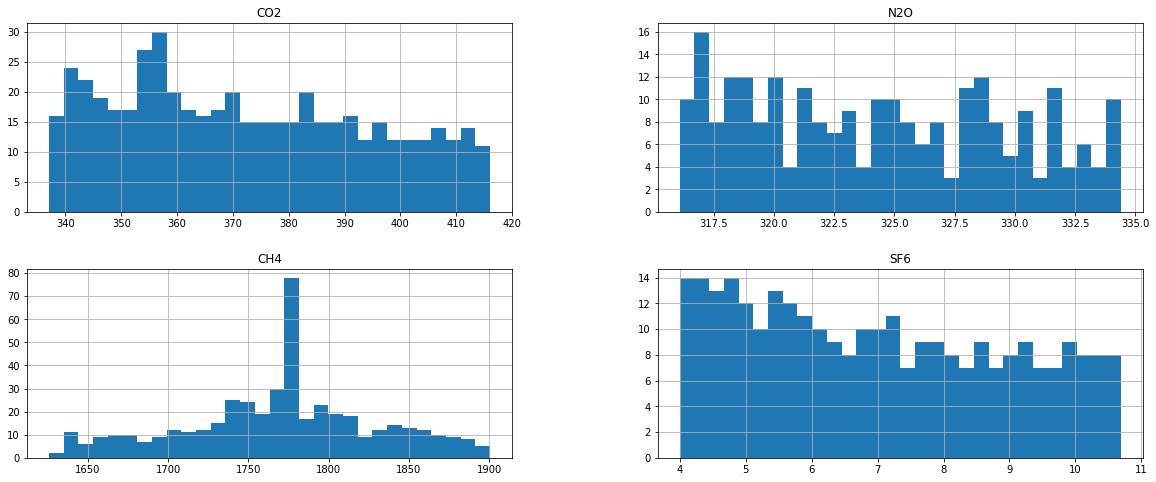

In [9]:
# Histograma de los datos
data_mensual.hist(column=["CO2","N2O","CH4","SF6"],bins=30, figsize=(20, 8))

#### Representación de los datos

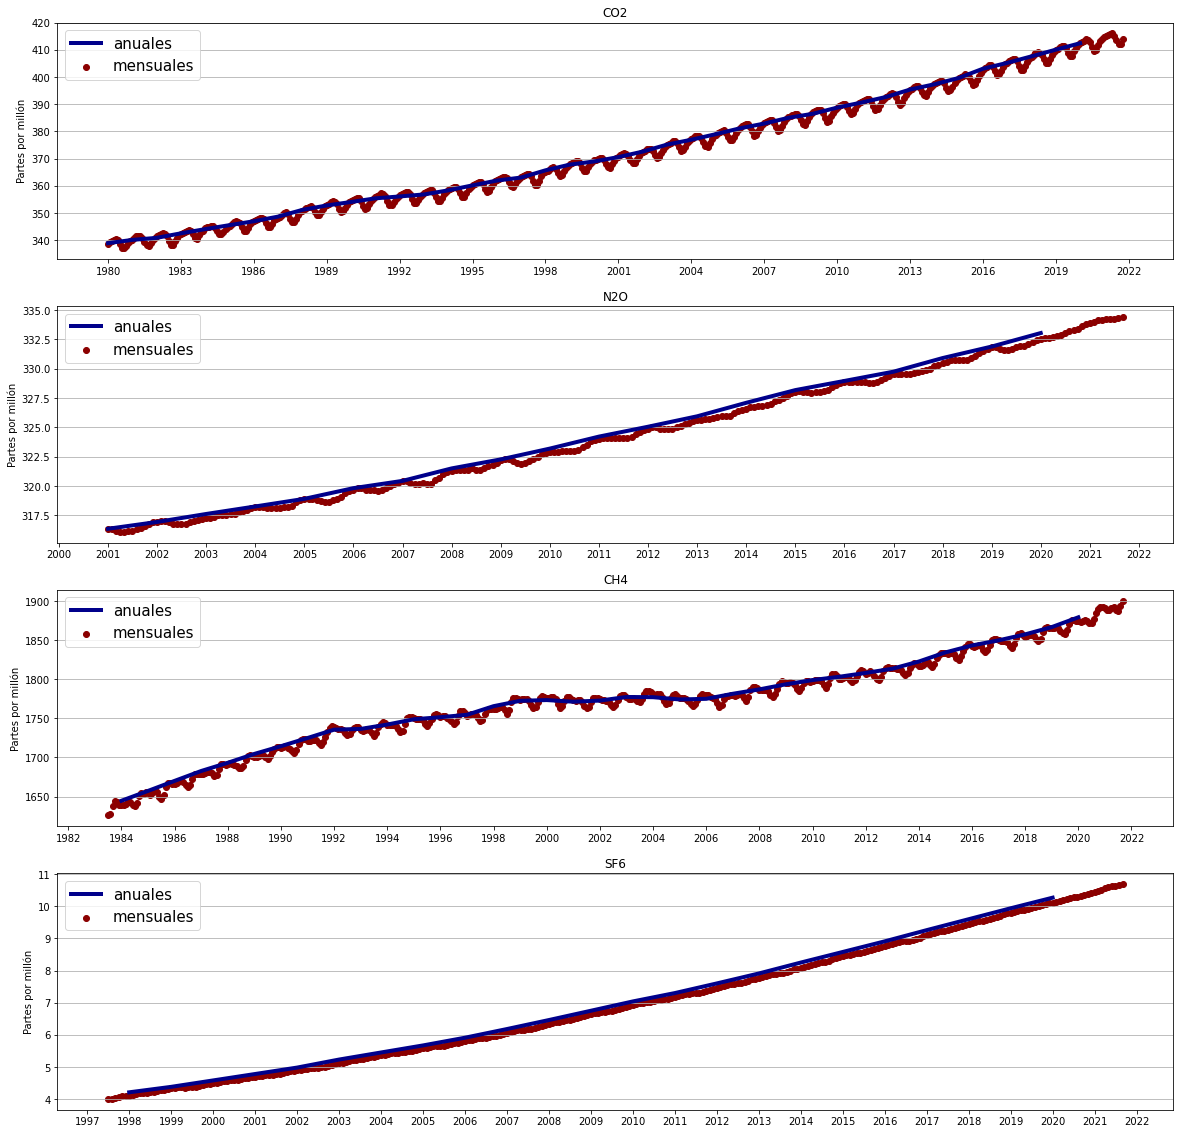

In [10]:
# Representación de los datos mensuales y anuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)

b=["CO2","N2O","CH4","SF6"]
year=[3,1,2,1]

for i in range(len(b)):

    ax[i].scatter(data_mensual.index,data_mensual[b[i]],c="darkred",label="mensuales")
    ax[i].plot(data_anual.index,data_anual[b[i]],c="darkblue",lw=4,label="anuales")

    ax[i].set_title(b[i])
    ax[i].yaxis.grid()
    ax[i].set_ylabel('Partes por millón')
    ax[i].legend(fontsize=15, loc="upper left")

    ax[i].xaxis.set_major_locator(mdates.YearLocator(year[i]))
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].tick_params(axis='x', rotation=0)

#### Distribución de los datos

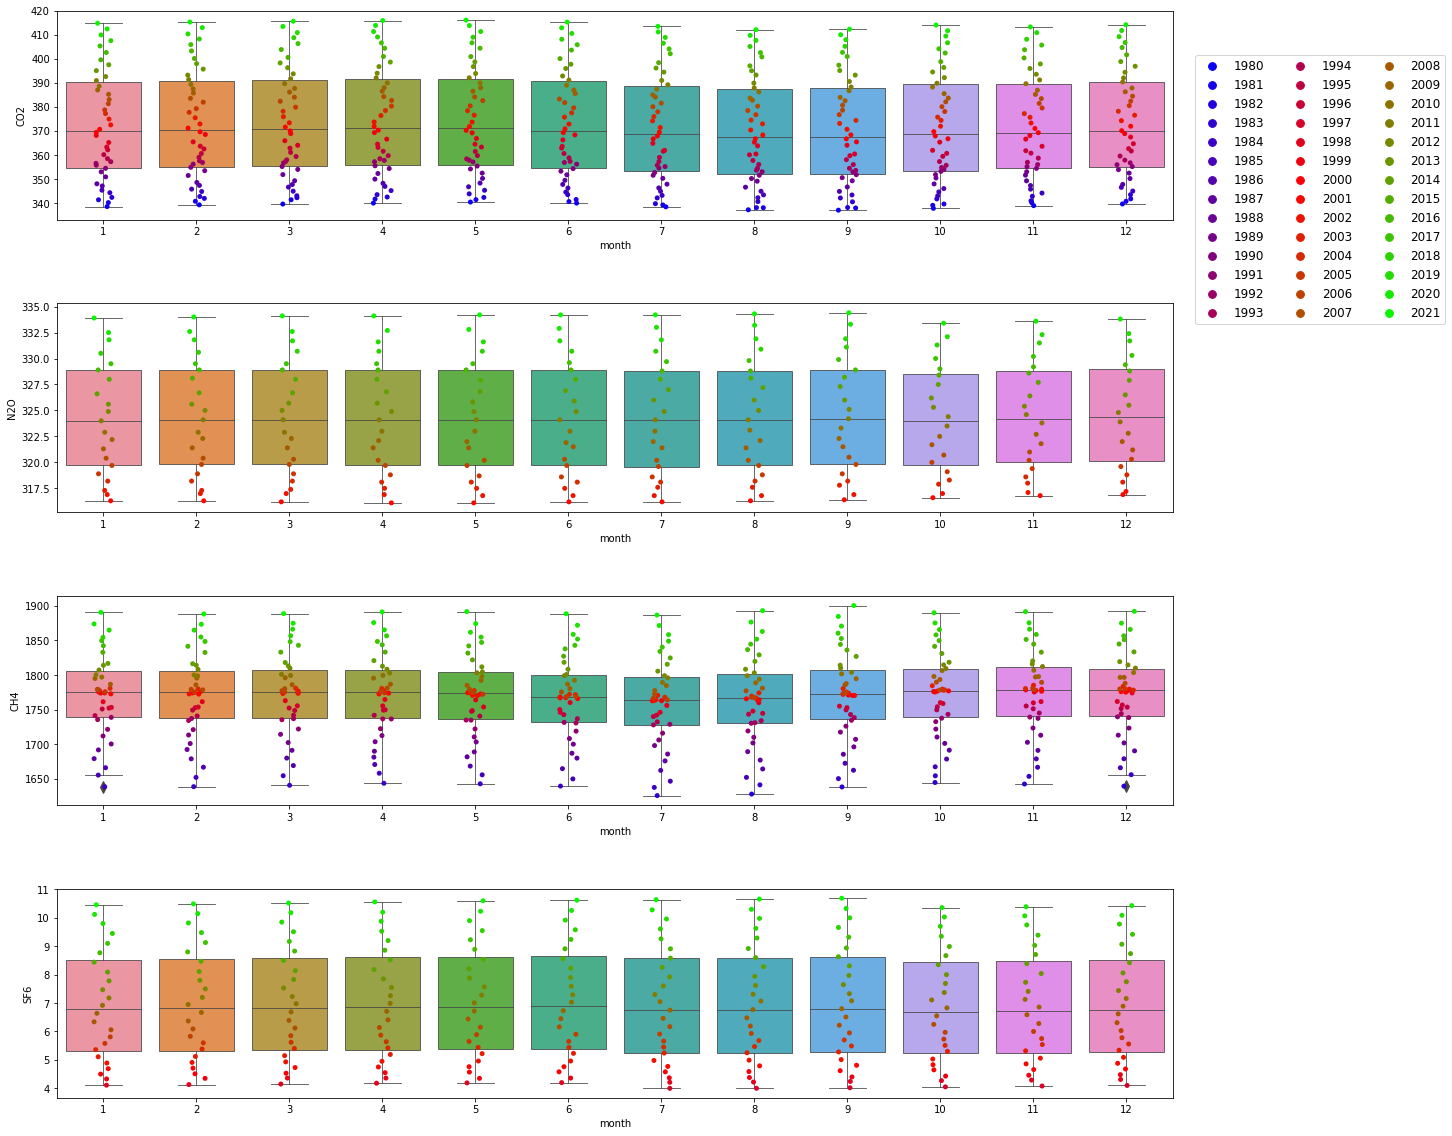

In [11]:
# Boxplot de los datos de cada gas para cada mes + scatterplot de los datos mensuales
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(20,20),sharex=False)
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    sns.stripplot(x=data_month["month"], y=data_month[a[i]],hue=data_month["year"],ax=ax[i],size=5,jitter=True,
                 palette='brg')
    sns.boxplot(x=data_month["month"], y=data_month[a[i]],ax=ax[i],fliersize=8,linewidth=0.8)

    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend('',frameon=False)
    ax[0].legend(handles, labels,loc=(1.02,-0.5),fontsize=12,ncol=3)

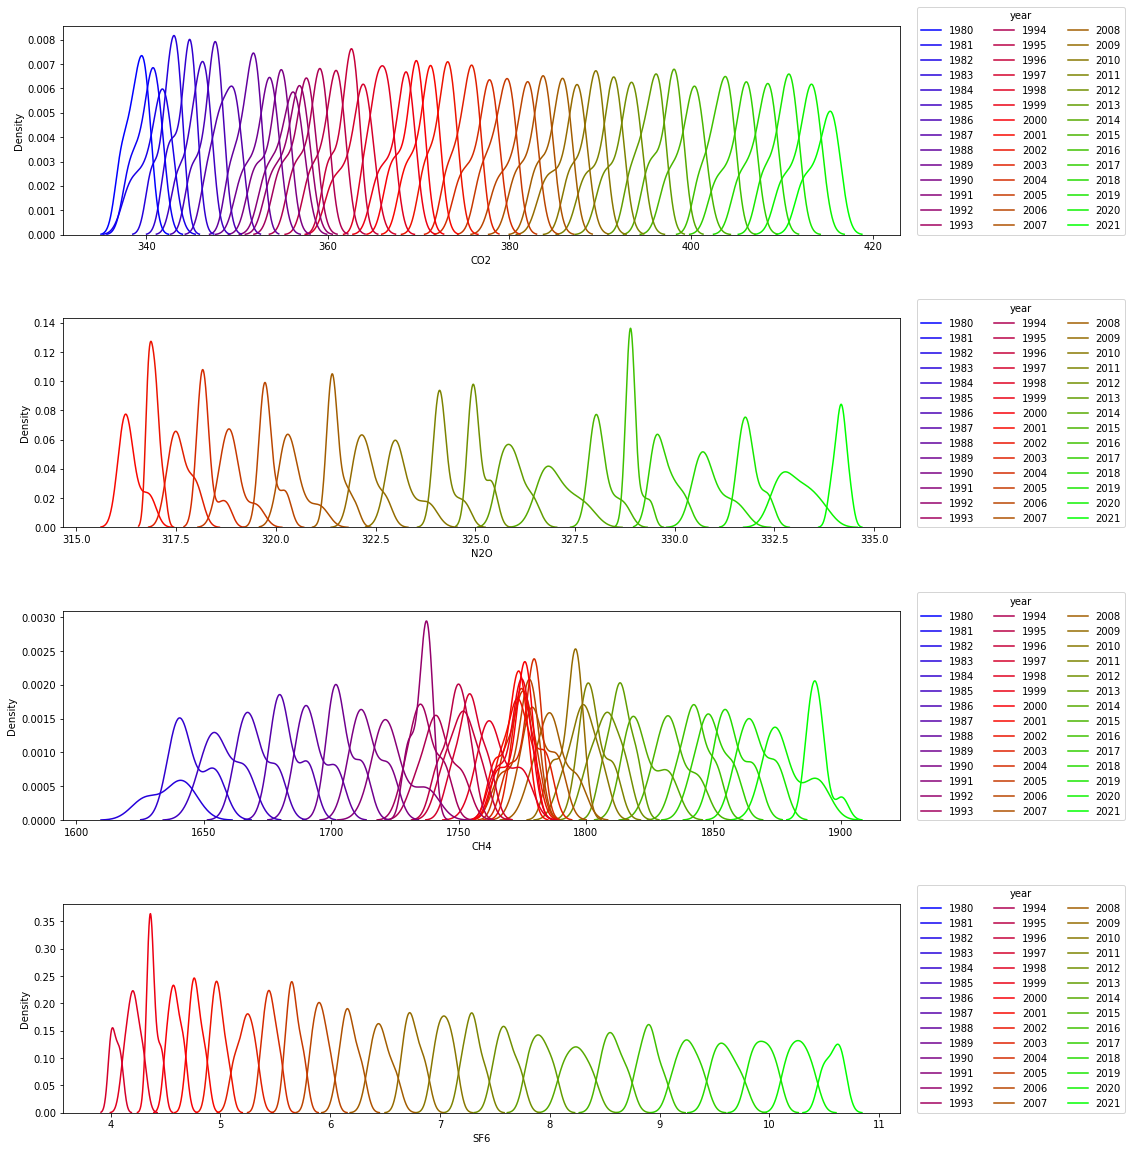

In [12]:
# Representación de la distrubución (KDE) por años  de los gases medidos cada mes
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

a=["CO2","N2O","CH4","SF6"]

for i in range(len(a)):
    ax = fig.add_subplot(4, 1, i+1)
    plot=sns.kdeplot(x=data_month[a[i]].dropna(axis=0),hue=data_month["year"].dropna(axis=0),
                     palette='brg',ax=ax,warn_singular=False)
    sns.move_legend(ax, ncol=3, loc=(1.02,0))


#### Estudio de la estacionariedad -> forcasting

In [13]:
def mean_var_sec(gas):
    X = data_month[gas].dropna(axis=0)
    
    split = int(len(X) / 4)
    X1, X2,X3,X4 = X[0:split],X[split:split*2],X[split*2:split*3], X[split*3:]
    mean1,mean2,mean3,mean4 = X1.mean(), X2.mean(), X3.mean(), X4.mean()
    var1,var2,var3,var4 = X1.var(), X2.var(),X3.var(), X4.var()
    print('mean1={:.3f}, mean2={:.3f}, mean3={:.3f}, mean4={:.3f}'.format(mean1, mean2,mean3, mean4))
    print('variance1={:.3f}, variance2={:.3f}, variance3={:.3f}, variance4={:.3f}'.format(var1, var2,var3, var4))

In [14]:
b=["CO2","N2O","CH4","SF6"]

for i in range(len(b)):
    print("\n-- " + str(b[i])+":")
    mean_var_sec(b[i])


-- CO2:
mean1=345.558, mean2=360.839, mean3=379.968, mean4=402.676
variance1=24.677, variance2=24.879, variance3=38.615, variance4=59.146

-- N2O:
mean1=317.692, mean2=321.679, mean3=326.503, mean4=331.565
variance1=1.018, variance2=1.811, variance3=2.366, variance4=2.849

-- CH4:
mean1=1689.102, mean2=1758.126, mean3=1784.698, mean4=1845.463
variance1=999.635, variance2=197.958, variance3=133.230, variance4=692.993

-- SF6:
mean1=4.591, mean2=5.946, mean3=7.628, mean4=9.639
variance1=0.120, variance2=0.197, variance3=0.282, variance4=0.384


In [15]:
# Test de Dickey-Fuller

b=["CO2","N2O","CH4","SF6"]

for i in range(len(b)):
    result = adfuller(data_month[b[i]].dropna(axis=0))
    print("\n-- " + str(b[i])+":")
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])


-- CO2:
Test statistic:  3.2637906387007214
p-value:  1.0
Critical Values: {'1%': -3.4439615820186846, '5%': -2.8675425624806605, '10%': -2.5699671340268937}

-- N2O:
Test statistic:  2.4215042482725706
p-value:  0.9990200730342839
Critical Values: {'1%': -3.4584868856997004, '5%': -2.873918902362675, '10%': -2.573367247623359}

-- CH4:
Test statistic:  0.011125875265417137
p-value:  0.9594425735326064
Critical Values: {'1%': -3.445231637930579, '5%': -2.8681012763264233, '10%': -2.5702649212751583}

-- SF6:
Test statistic:  3.3893980112741158
p-value:  1.0
Critical Values: {'1%': -3.454355055831705, '5%': -2.8721080938842976, '10%': -2.572401325619835}


** Ninguna de las series temporales son estacionarias. Se aprecia una clara tendencia ascendente dependiente del tiempo